In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
# Импортируем датасет
DATADIR = './data/08'
data = pd.read_csv('/'.join([DATADIR, 'winequality-red.csv']), delimiter=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Целевой метрикой является столбец quality в диапазоне от 3 до 8

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Датасет не содержит пропущенные значения

In [4]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<AxesSubplot:>

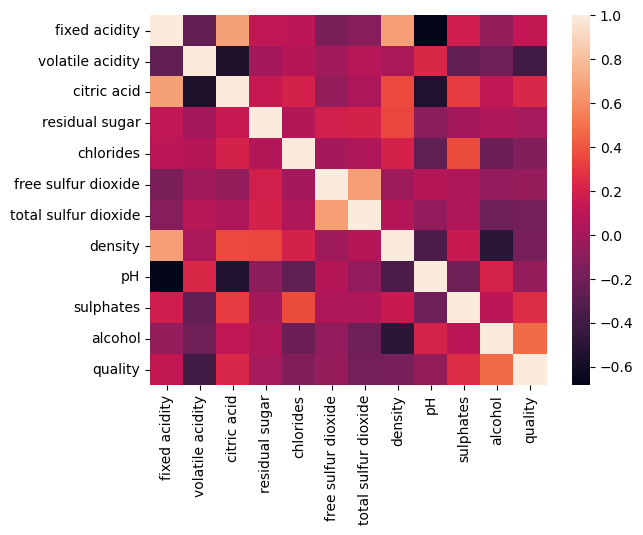

In [5]:
# Оценим корреляцию признаков
sns.heatmap(data.corr())

Можно выделить корреляцию с целевым такие признаки, как алкоголь, кислотность и сульфаты

In [6]:
# Сформируем новый признак просуммировав данные кислотности
data['acid'] = data['fixed acidity'] + data['volatile acidity'] + data['citric acid']

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>,
        <AxesSubplot:title={'center':'residual sugar'}>],
       [<AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>,
        <AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>],
       [<AxesSubplot:title={'center':'acid'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

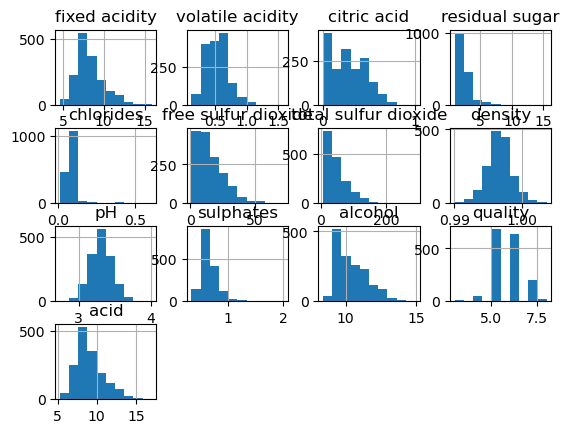

In [7]:
# Посмотрим на распределение
data.hist()

In [8]:
# Категоризируем целевую переменную. Будем считать, что качество вина: плохое < 6,5 < хорошее
data.quality = (data.quality>6.5).astype(int)

In [9]:
# Преобразуем признаки при помощи StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop(['quality'], axis=1)), columns=data.drop(['quality'], axis=1).columns)
data_scaled['quality'] = data['quality']

In [10]:
def get_bounds(series):
    """ Функция возвращает границы выбросов """
    series_iqr = iqr(series)
    upper = np.percentile(series, 75) + series_iqr
    bottom = np.percentile(series, 25) - series_iqr
    return (bottom, upper)

In [11]:
# Пройдёмся по колонкам, уберём выбросы
for column in ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']:
    bottom, upper = get_bounds(data_scaled[column])
    data_scaled = data_scaled.loc[data_scaled[column].between(bottom, upper)]

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>,
        <AxesSubplot:title={'center':'residual sugar'}>],
       [<AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>,
        <AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'acid'}>],
       [<AxesSubplot:title={'center':'quality'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

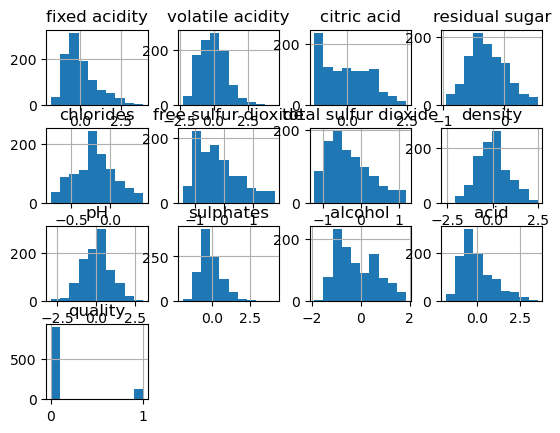

In [12]:
# Оценим результат
data_scaled.hist()

Получили распределение близкое к нормальному.

In [13]:
# Обратим внимание на то, что целевая переменная несбалансированна
data_scaled.quality.value_counts()

0    895
1    125
Name: quality, dtype: int64

In [14]:
# Разобъем датасет на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop(['quality'], axis=1), data_scaled['quality'], test_size=0.3, random_state=42)

Подготовим гиперпараметры и с помощью RandomizedSearchCV подберем оптимальные

In [15]:
C_range = np.logspace(-2, 4, 5)
gamma_range = np.logspace(-9, 3, 5)
kernels =  ['linear', 'poly', 'rbf', 'sigmoid']

search_space = dict(C=C_range, gamma=gamma_range, kernel=kernels)

In [22]:
# Будем использовать стратифицированный перекрестный блок проверки допустимости ShuffleSplit
cv=StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

In [23]:
# В качестве модели используем SVC
model = SVC(random_state=42)

In [24]:
random_search = RandomizedSearchCV(model, param_distributions=search_space, n_iter=10, cv=cv, n_jobs = -1, scoring='accuracy')
model_random = random_search.fit(X_train, y_train)

In [25]:
# Наиболее оптимальные параметры
model_random.best_params_

{'kernel': 'rbf', 'gamma': 1.0, 'C': 316.22776601683796}

In [26]:
# Результат
model_random.best_score_

0.8857808857808859

Так же, оценим результат с помощью confusion_matrix

In [27]:
y_pred = model_random.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[263   6]
 [ 25  12]]


Получили вполне неплохой результат. Можно улучшить добавив ещё полиномиальных признаков и задать б`ольший диапазон гиперпараметров при поиске оптимальных значений.